### Transfer Learning

**Transfer learning** allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as ImageNet (millions of images of different objects) and use them to power our own projects

#### Where can we find pretrained models?
*  PyTorch domain libraries
*  HuggingFace Hub
*  Paperswithcode etc.<br>
https://pytorch.org/vision/stable/models.html

### Import necessary Libraries

In [1]:
import torch
import torchvision

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [3]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3808, done.
remote: Counting objects: 100% (451/451), done.
remote: Compressing objects: 100% (266/266), done.
remote: Total 3808 (delta 234), reused 356 (delta 178), pack-reused 3357
Receiving objects: 100% (3808/3808), 650.23 MiB | 18.27 MiB/s, done.
Resolving deltas: 100% (2190/2190), done.
Updating files: 100% (248/248), done.


#### Renaming 

In [5]:
import os

old_name = r"./going_modular"
new_name = r"./scripts"
os.rename(old_name, new_name)

In [6]:
old_name = r"./scripts/going_modular"
new_name = r"./scripts/scripts"
os.rename(old_name, new_name)

In [7]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
# Check the GPU
!nvidia-smi

Mon May 22 17:22:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Get Data

In [9]:
# Download data

import os
import zipfile

from pathlib import Path

import requests


# Setup data path
data_path = Path("data/")

image_path = data_path/"pizza_steak_sushi"

# If data path doesnot exist, create one
if data_path.is_dir():
  print(f"{data_path} already exists, Not going to create again")
else:
  os.mkdir("data")

# If image path doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download")
else:
  print(f"Didnot found {image_path}, downloading it .....")
  

  # Download data from github
  with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading .......")
    f.write(request.content)


  # Unzip downloaded data
  with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data ...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path/"pizza_steak_sushi.zip")

Didnot found data/pizza_steak_sushi, downloading it .....
Unzipping pizza, steak, sushi data ...


In [10]:
# Setup directory path

train_dir = image_path/ "train"
test_dir = image_path/ "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Image folders to Datasets and DataLoaders

Here, we are using transfer learning. <br>

A point to remember while using a pretrained model is that the data we pass through the model is transformed the same way the training data was passed while training the model.<br>

`torchvision.models` contains pretrained models (models ready for transfer learning).

#### Creating transforms for `torchvision.models` using automatic data transform creation



*   Get a set of pretrained model weights. Here, in our case, we'll use `EfficientNet_BO_Weights`.



In [11]:
## Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # "DEFAULT" = best available weights

In [12]:
# Check the weights object
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

Now, we can get the transforms by just calling the `.transforms()` method.

In [13]:
auto_transforms = weights.transforms()

In [14]:
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

#### Creating DataLoaders using automatic transforms

In [15]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir, test_dir = test_dir, transform = auto_transforms, batch_size = 32)

In [16]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f40def445b0>,
 ['pizza', 'steak', 'sushi'])

### Choosing the best pretrained model

There are thousands of pretrained models, but how to know which one is perfect  for us.

We consider 3 things before selecting a pretrained model.
1. Speed
2. Size
3. Performance

We have chosen `Efficient_Net_B0` by looking at performance to parameters ratio.

#### Setting up Pretrained model.

In [17]:
# Create a pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT      # "DEFAULT" = best available weights

# Setting up the model
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 27.9MB/s]


In [18]:
# Let's check the model
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Feature Extraction

In [19]:
# Getting a summary of our model with torchinfo
from torchinfo import summary

summary(model = model, 
        input_size = (1, 3, 224, 224),  # batch_size = (batch_size, color channels, height, width)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

Right now, all the parameters of our models are trainable. But, we'd like to only train the `sequential` layer. So, we need to convert `Trainable` to `False` for rest of the layers.

In [20]:
# Freezing the base model and changing the output layer to suit our needs
for param in model.features.parameters():
  param.requires_grad = False

In [21]:
summary(model = model, 
        input_size = (1, 3, 224, 224),  # batch_size = (batch_size, color channels, height, width)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [23]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Update the classifier head of pretrained model to suit our model architecture

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2,
               inplace = True),
               nn.Linear(in_features = 1280,
                         out_features = len(class_names))).to(device)


model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [24]:
summary(model = model, 
        input_size = (1, 3, 224, 224),  # batch_size = (batch_size, color channels, height, width)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Train the model

In [25]:
# Define the loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [27]:
# Import training function script
from scripts.scripts import engine

# Set maunal seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
import time
start_time = time.time()


# Setup training and save models
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

# End time
end_time = time.time()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
[INFO] Total training time: 17.204 seconds


We have reached near 90% accuracy & that too in test_set in 5 epochs, 18 seconds and training just 3,843 parameters.

### Plotting the loss curves 

In [28]:
results

{'train_loss': [1.092943362891674,
  0.8702964261174202,
  0.7647757083177567,
  0.7114483937621117,
  0.6252278387546539],
 'train_acc': [0.40234375, 0.77734375, 0.80078125, 0.7578125, 0.79296875],
 'test_loss': [0.9124558766682943,
  0.7900150219599406,
  0.7433413664499918,
  0.6344443957010905,
  0.6237563093503317],
 'test_acc': [0.5501893939393939,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8863636363636364]}

In [44]:
# Download helper function
with open("./helper_functions.py", "w") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  print("Downloading .......")
  f.write(request.text)


In [45]:
# Move it to scripts

!mv "/content/helper_functions.py" "/content/scripts/scripts"

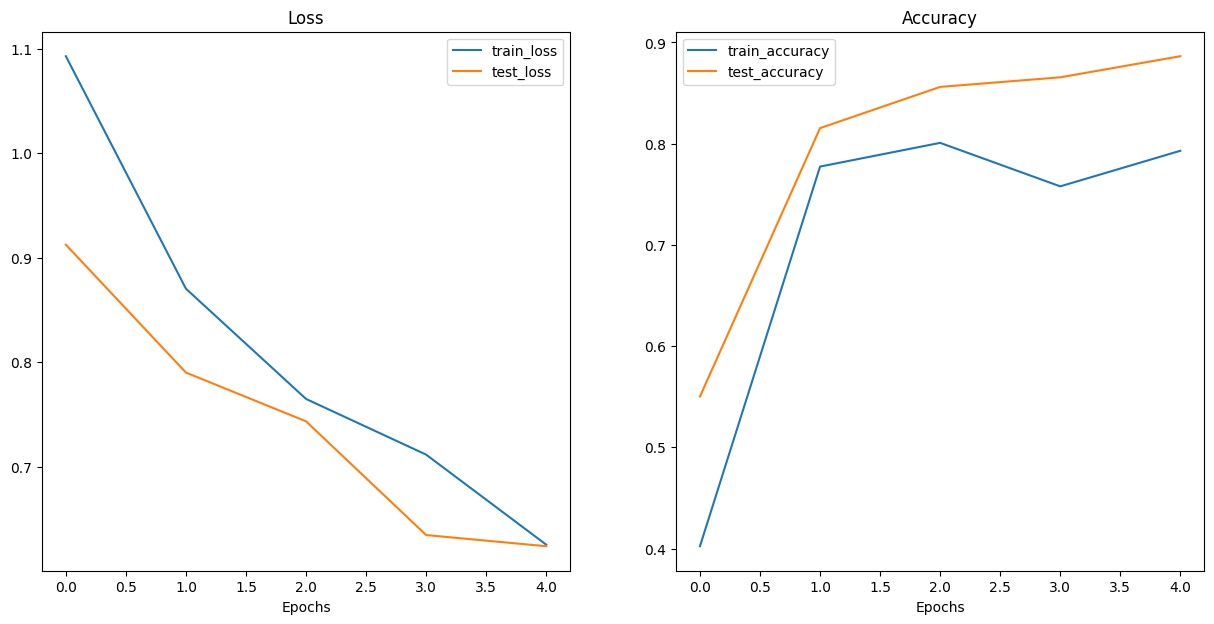

In [47]:
from scripts.scripts import helper_functions

helper_functions.plot_loss_curves(results)